In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

import scipy as osp
from scipy.stats import kde

from numpy.polynomial.hermite import hermgauss

import paragami

import matplotlib.pyplot as plt
%matplotlib inline

from bnpmodeling_runjingdev import cluster_quantities_lib, result_loading_utils

from structure_vb_lib import structure_model_lib, posterior_quantities_lib, plotting_utils
from structure_vb_lib.data_utils import cluster_admix_get_indx

import re
import copy

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# File paths

In [3]:
# data_file='../data/phased_HGDP+India+Africa_2810SNPs-regions1to36.npz'
# out_filename='huang2011_fit'
# out_folder='../fits/hgdp_fits/'

data_file = '../data/huang2011_sub_nobs25_nloci75.npz'
out_filename = 'huang2011_fit_sub'
out_folder = '../fits/tmp/'


In [28]:
alpha0 = 6.0

In [5]:
# class with method to load all files from a particular perturbation
result_loader = result_loading_utils.FunctionalRefitsLoader(alpha0, 
                                                            out_folder, 
                                                            out_filename)

loading initial fit from:  ../fits/tmp/huang2011_fit_sub_alpha6.0.npz
loading lr derivatives from:  ../fits/tmp/huang2011_fit_sub_alpha6.0_lrderivatives.npz


# Load data

In [6]:
print(data_file)

../data/huang2011_sub_nobs25_nloci75.npz


In [7]:
data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)

# Load initial fit and other model parameters

In [9]:
vb_init_free = result_loader.vb_init_free
vb_params_paragami = result_loader.vb_params_paragami
vb_init_dict = vb_params_paragami.fold(vb_init_free, free = True)

In [10]:
vb_init_free = vb_params_paragami.flatten(vb_init_dict, free = True)

In [11]:
# gauss-hermite parameters
gh_deg = int(result_loader.init_fit_meta_data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

gh_loc = np.array(gh_loc)
gh_weights = np.array(gh_weights)
    
# load prior parameters
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

# set initial alpha
assert alpha0 == result_loader.init_fit_meta_data['dp_prior_alpha']
prior_params_dict['dp_prior_alpha'] = alpha0

print(prior_params_dict)


{'dp_prior_alpha': 6.0, 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


# Function to get posterior statistics

In [12]:
def get_e_ind_admix(vb_free_params): 
    
    # this returns the expected individual mixture proportions. 

    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(stick_means, 
                                                                     stick_infos, 
                                                                     gh_loc, 
                                                                     gh_weights)
    return e_ind_admix

### Plot initial fit

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


Text(0.5, 0, 'Individuals')

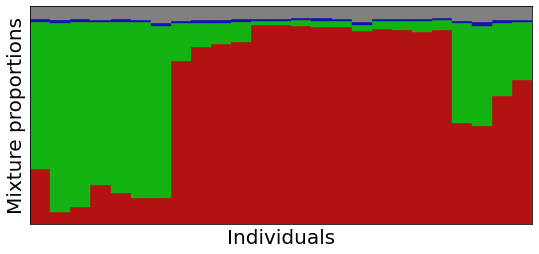

In [13]:
e_ind_admix_init = get_e_ind_admix(vb_init_free)

# re-order individuals for better plotting
admix_perm = cluster_admix_get_indx(e_ind_admix_init)

f, axarr = plt.subplots(1, 1, figsize=(9, 4))
_ = plotting_utils.plot_top_clusters(e_ind_admix_init[admix_perm], axarr, 
                                               n_top_clusters = 3)

axarr.set_ylabel('Mixture proportions', fontsize = 20)
axarr.set_xlabel('Individuals', fontsize = 20)

### Plot co-clustering

In [14]:
def plot_coclustering(e_ind_admix_refit, e_ind_admix_lr, e_ind_admix_init): 
    
    fig, ax = plt.subplots(1, 4, figsize = (16, 3))
    
    # compute co-clustering matrix 
    coclust_init = np.dot(e_ind_admix_init, 
                          e_ind_admix_init.transpose())
    coclust_refit = np.dot(e_ind_admix_refit,
                           e_ind_admix_refit.transpose())
    coclust_lr = np.dot(e_ind_admix_lr,
                        e_ind_admix_lr.transpose())
    
    
    # plot diff colormaps
    result_loading_utils.plot_colormaps(coclust_refit,
                                        coclust_lr,
                                        coclust_init,
                                        fig, ax[2:], 
                                        plot_initial = False)
    
    # plot diff in expected individual belongings
    result_loading_utils.print_diff_plot(e_ind_admix_refit.flatten(), 
                                         e_ind_admix_lr.flatten(),
                                         e_ind_admix_init.flatten(), 
                                         ax[0],
                                         alpha = 0.05)
    
    
    # plot diff in coclustering
    result_loading_utils.print_diff_plot(coclust_refit.flatten(), 
                                         coclust_lr.flatten(),
                                         coclust_init.flatten(), 
                                         ax[1],
                                         alpha = 0.05)

        
    return fig, ax

### Function to make trace plots

In [15]:
@jax.jit
def get_diff_in_e_ind_admix(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    e_ind_admix = get_e_ind_admix(vb_free)
    
    e_ind_admix0 = get_e_ind_admix(vb_init_free)
    
    return np.abs(e_ind_admix - e_ind_admix0).mean()

In [16]:
@jax.jit
def get_diff_in_coclustering(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    e_ind_admix = get_e_ind_admix(vb_free)
    coclust_matr = np.dot(e_ind_admix, e_ind_admix.transpose())
    
    e_ind_admix0 = get_e_ind_admix(vb_init_free)
    coclust_matr0 = np.dot(e_ind_admix0, e_ind_admix0.transpose())
    
    return np.abs(coclust_matr - coclust_matr0).mean()

### Function to plot all results

In [17]:
def plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [-1]): 
    #################
    # load free parameters
    #################
    vb_refit_list, lr_list, epsilon_vec = \
        result_loader.get_free_param_results_from_perturbation(perturbation, delta)
    
    assert (vb_refit_list[0] == lr_list[0]).all()
    
    #################
    # see how our summary statistic changes
    #################
    fig, ax = plt.subplots(1, 3, figsize = (12, 3))
    result_loading_utils.plot_post_stat_per_epsilon(get_diff_in_e_ind_admix, 
                                                    vb_refit_list,
                                                    lr_list,
                                                    epsilon_vec,
                                                    ax[0])
    ax[0].set_ylabel('median. abs. error in ez')
    
    result_loading_utils.plot_post_stat_per_epsilon(get_diff_in_coclustering, 
                                                    vb_refit_list,
                                                    lr_list,
                                                    epsilon_vec,
                                                    ax[1])
    ax[1].set_ylabel('median. abs. error in coclust')
    ax[0].legend()
    
    for a in ax[0:2]: 
        for eps_indx in epsilon_indx_vec: 
            a.axvline(epsilon_vec[eps_indx],
                       color = 'grey',
                       linestyle = 'dashed')
    fig.tight_layout()

    ###############
    # initial admixture and coclustering
    ###############
    coclust_init = np.dot(e_ind_admix_init[admix_perm], e_ind_admix_init[admix_perm].transpose())
    ax[2].set_title('initial coclustering')
    im0 = ax[2].matshow(coclust_init, 
                        cmap = plt.get_cmap('Blues'))
    fig.colorbar(im0, ax = ax[2])

    for eps_indx in epsilon_indx_vec: 
        #################
        # get admixtures
        #################
        e_ind_admix_refit = get_e_ind_admix(vb_refit_list[eps_indx])
        e_ind_admix_lr = get_e_ind_admix(lr_list[eps_indx])

        #####################
        # plot co-clustering
        #####################
        fig, ax = plot_coclustering(e_ind_admix_refit[admix_perm], 
                                    e_ind_admix_lr[admix_perm],
                                    e_ind_admix_init[admix_perm])
        ax[0].set_title('diff in ez; epsilon = {:.03f}'.format(epsilon_vec[eps_indx]))
        ax[1].set_title('diff in coclust; epsilon = {:.03f}'.format(epsilon_vec[eps_indx]))
    
        fig.tight_layout()


# Plot results

# Sigmoidal perturbations

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.388126e-08
  warnings.warn(


Optim time at epsilon = 1: 5.786secs
Derivative time: 0.683secs


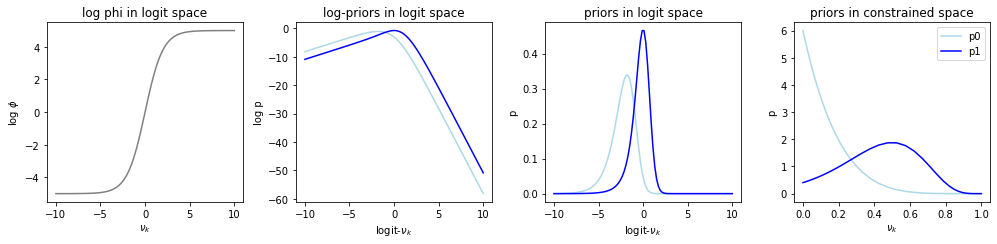

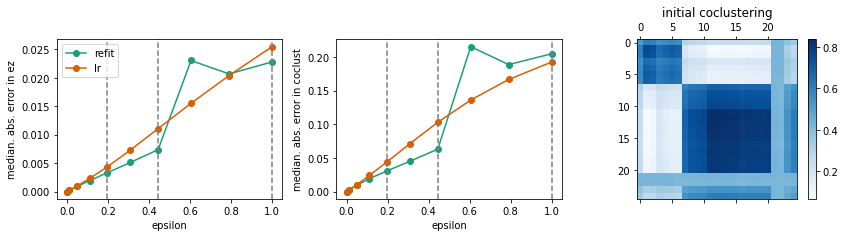

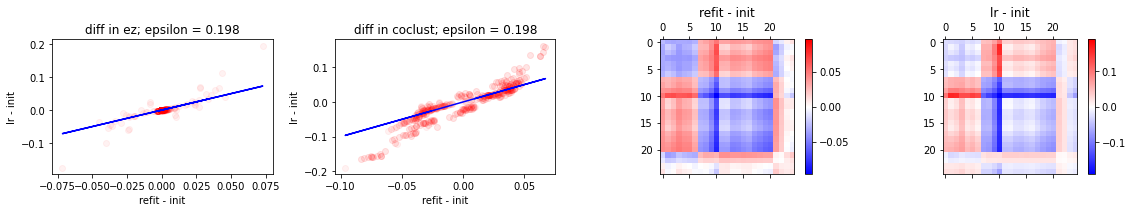

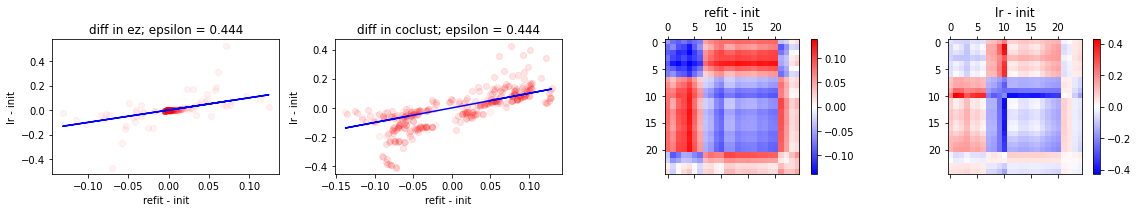

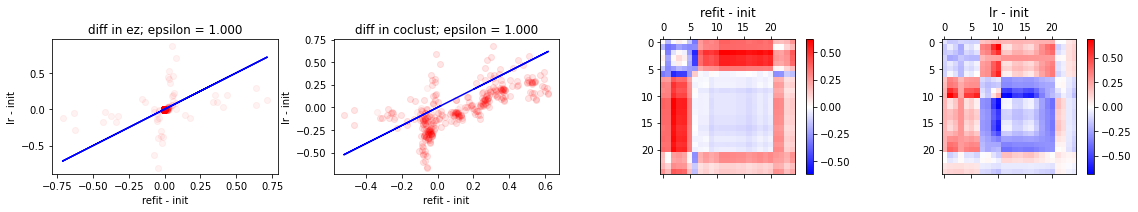

In [18]:
perturbation = 'sigmoidal'
delta = 5
result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [4, 6, -1])

Optim time at epsilon = 1: 2.959secs
Derivative time: 0.683secs


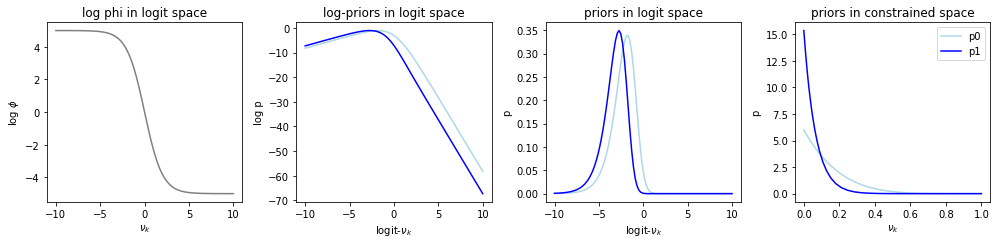

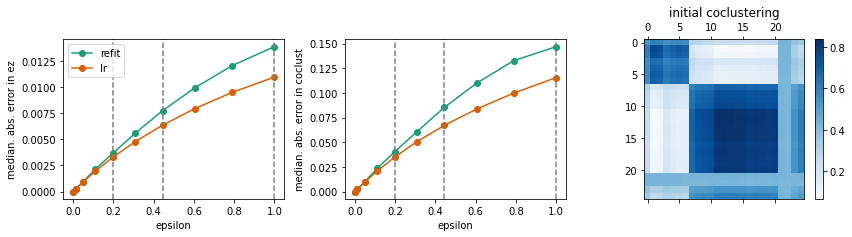

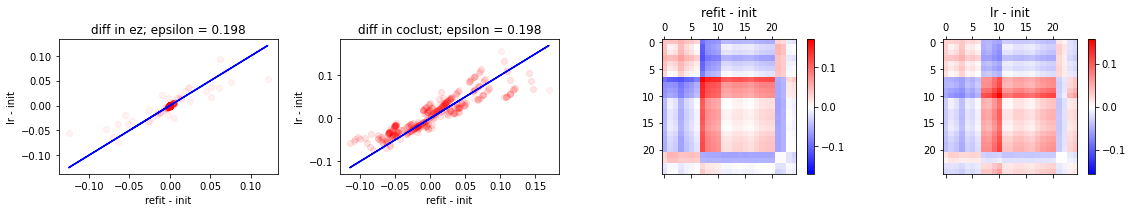

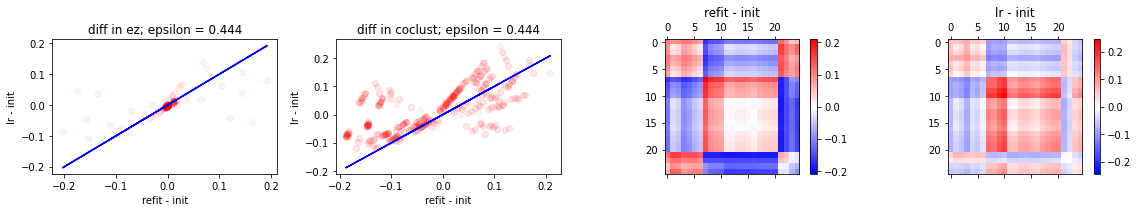

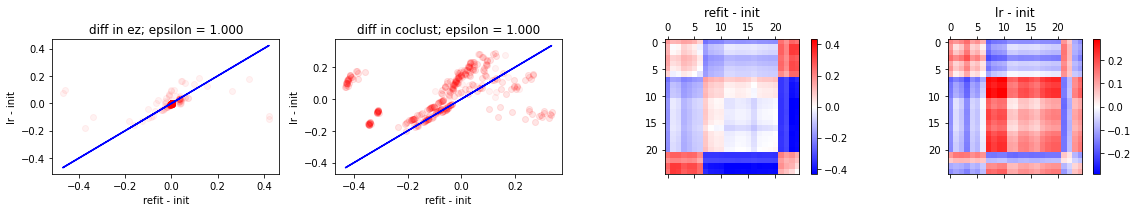

In [19]:
perturbation = 'sigmoidal'
delta = -5
result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [4, 6, -1])

# Perturbations corresponding to moving \alpha

Optim time at epsilon = 1: 7.319secs
Derivative time: 0.669secs


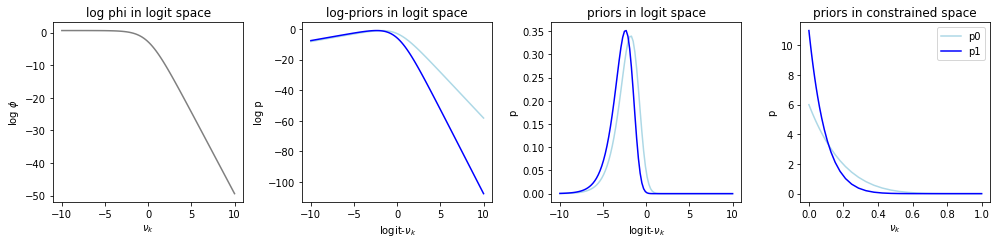

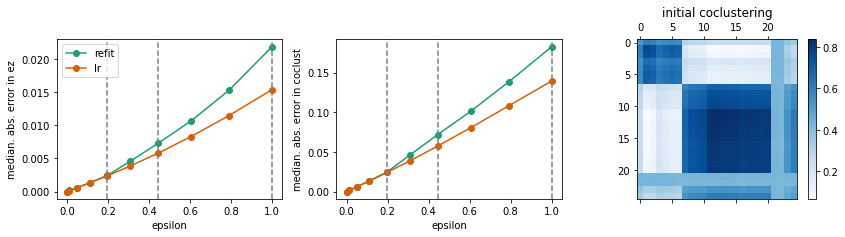

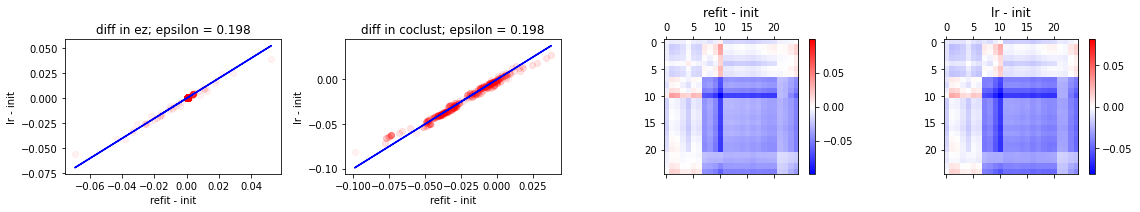

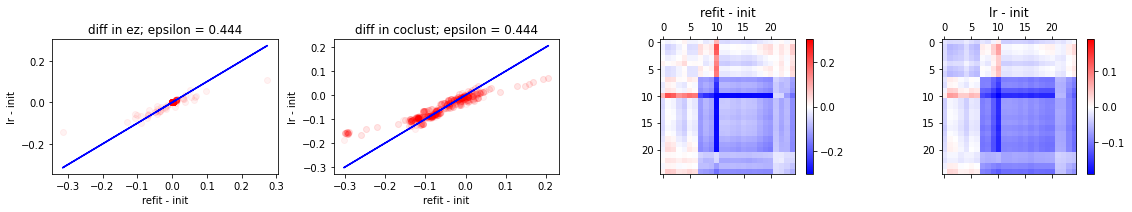

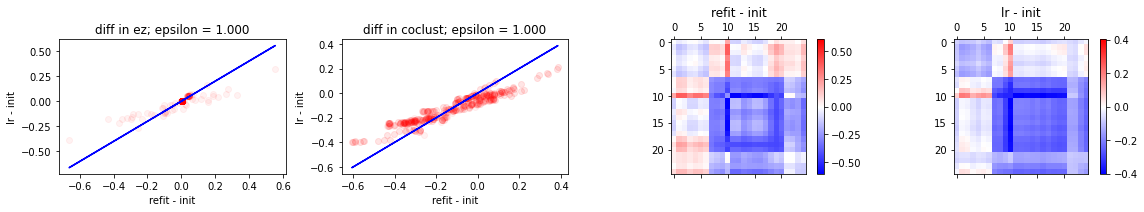

In [20]:
perturbation = 'alpha_pert_pos'
delta = 1
result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [4, 6, -1])

Optim time at epsilon = 1: 5.712secs
Derivative time: 0.666secs


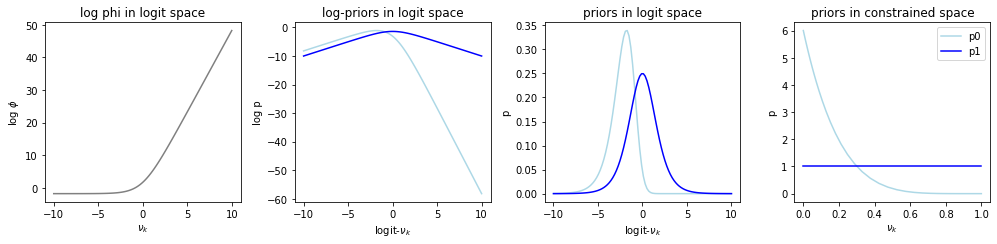

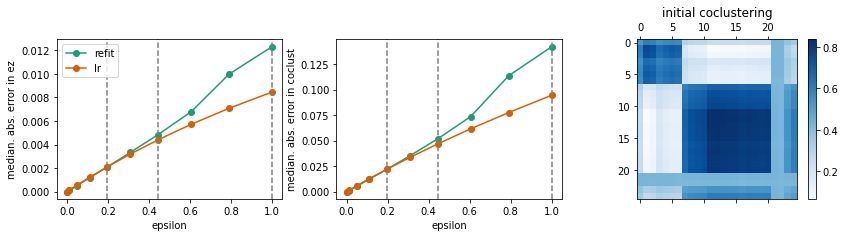

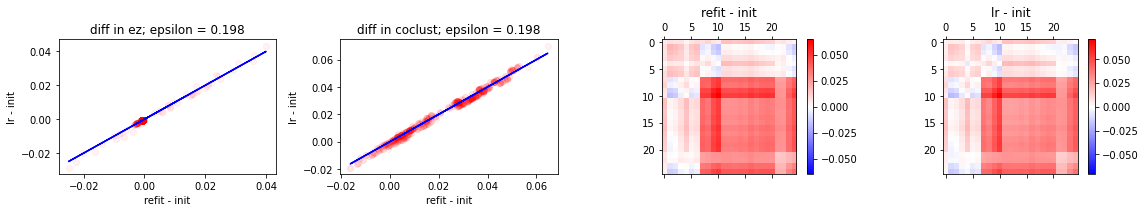

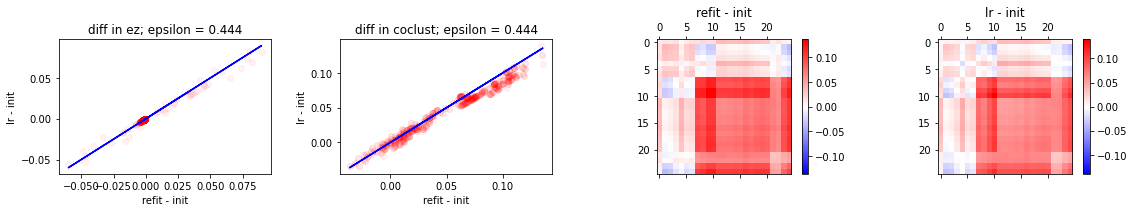

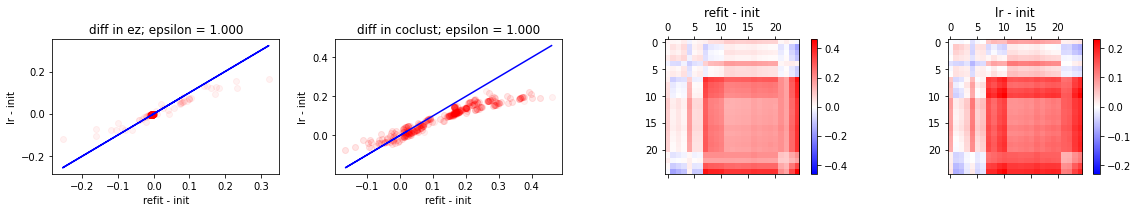

In [21]:
perturbation = 'alpha_pert_neg'
delta = 1
result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [4, 6, -1])

In [22]:
# perturbation = 'alpha_pert_pos_xflip'
# plot_perturbation(perturbation, delta = 1)
# plot_results_for_perturbation(perturbation, delta = 1)

In [23]:
# perturbation = 'alpha_pert_neg_xflip'
# plot_perturbation(perturbation)
# plot_results_for_perturbation(perturbation)

# Gaussian perturbations

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.227507e-06
  warnings.warn(


Optim time at epsilon = 1: 5.679secs
Derivative time: 0.684secs


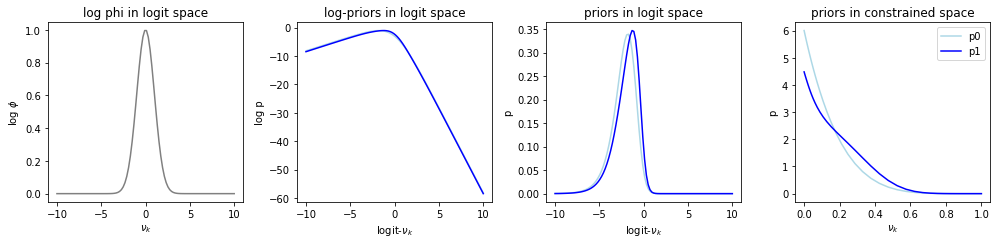

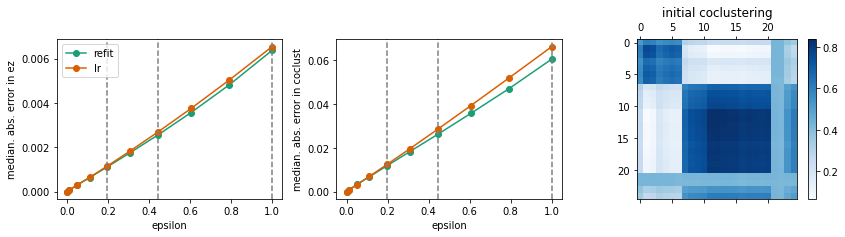

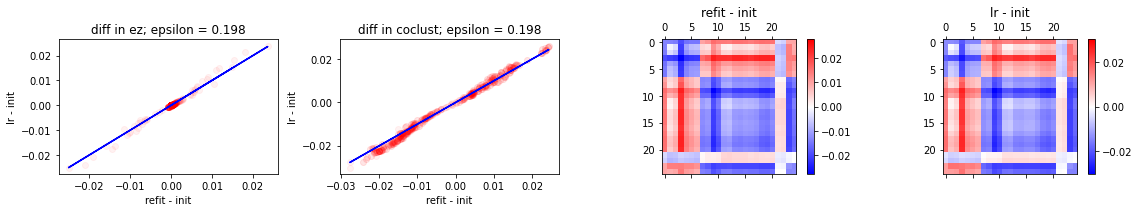

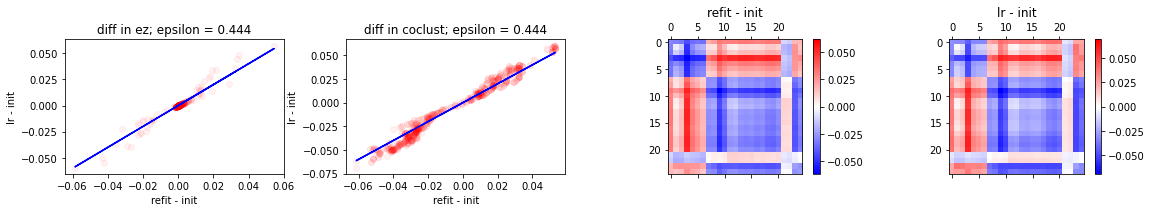

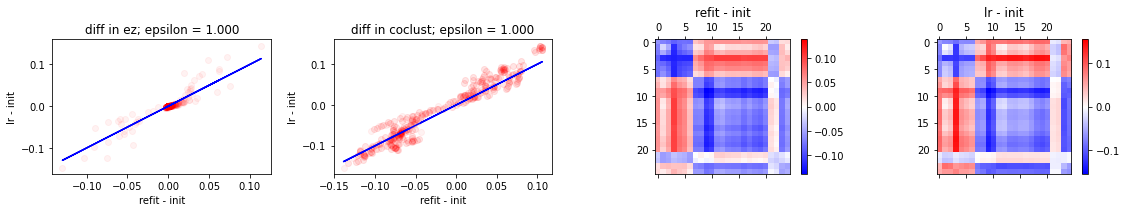

In [24]:
perturbation = 'gauss_pert1'
delta = 1
result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [4, 6, -1])

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.001209e-08
  warnings.warn(


Optim time at epsilon = 1: 5.522secs
Derivative time: 0.684secs


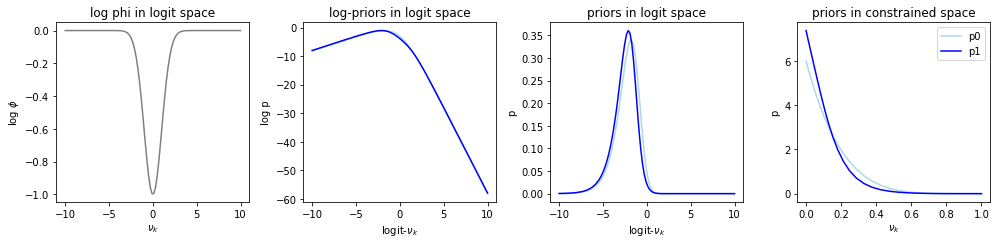

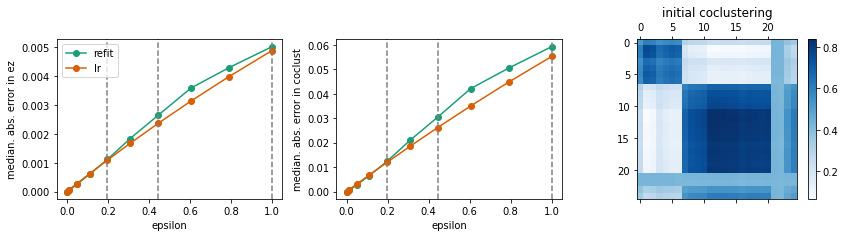

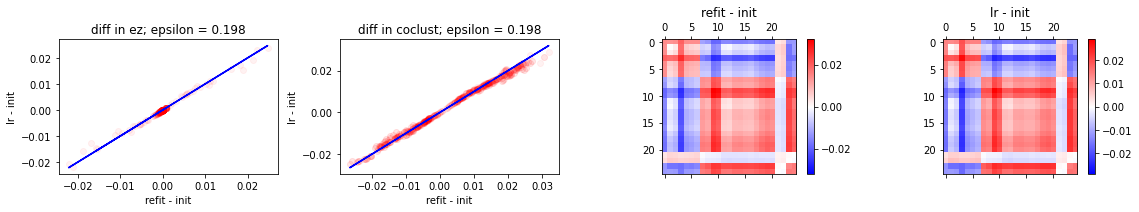

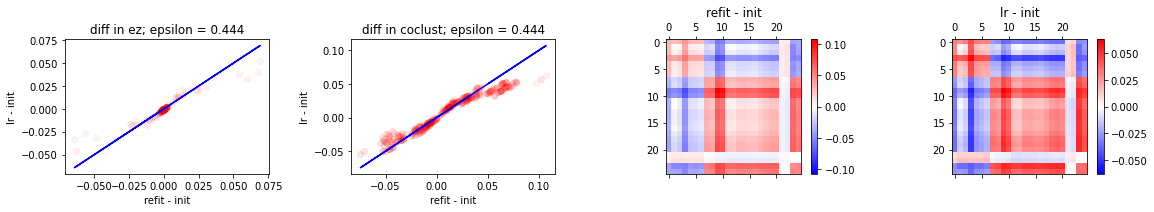

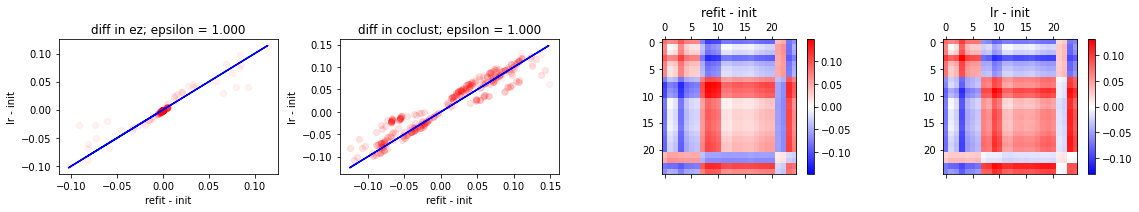

In [25]:
perturbation = 'gauss_pert1'
delta = -1
result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [4, 6, -1])

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.412626e-07
  warnings.warn(


Optim time at epsilon = 1: 3.965secs
Derivative time: 0.705secs


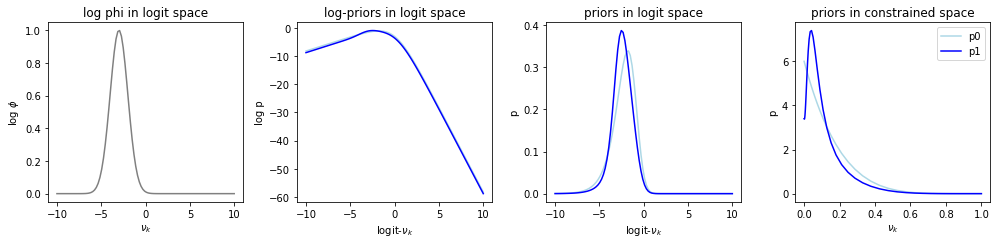

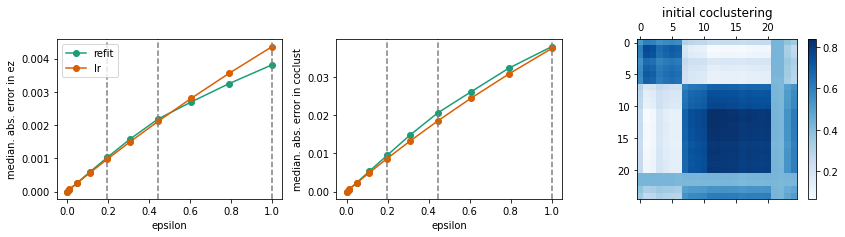

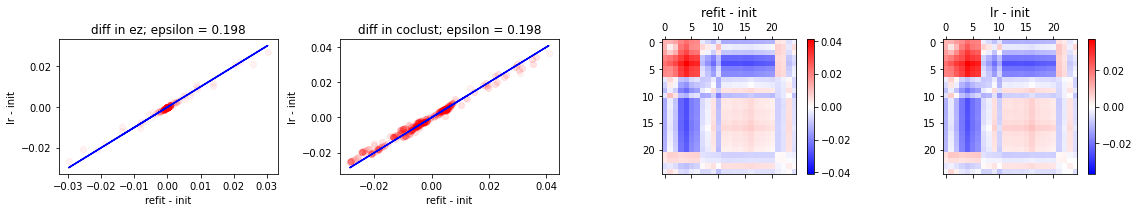

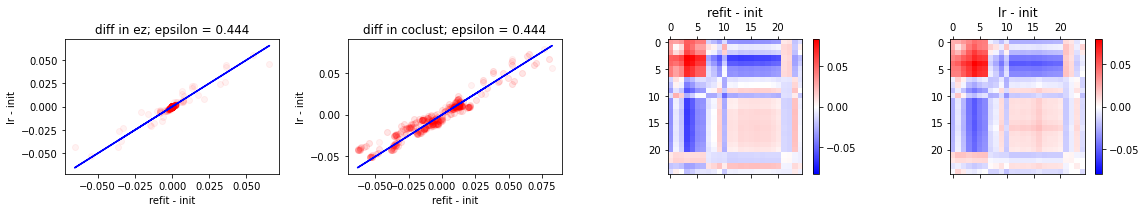

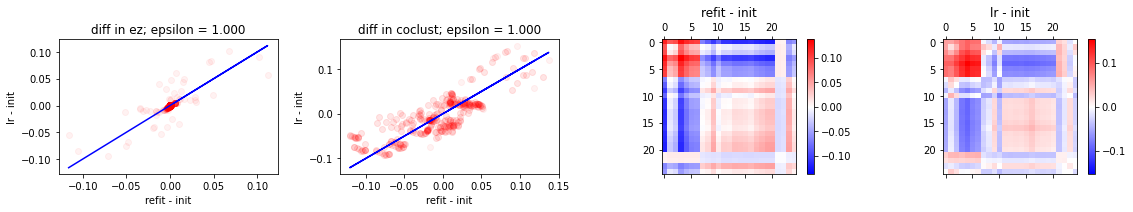

In [26]:
perturbation = 'gauss_pert2'
delta = 1
result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [4, 6, -1])

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.524900e-08
  warnings.warn(


Optim time at epsilon = 1: 4.589secs
Derivative time: 0.705secs


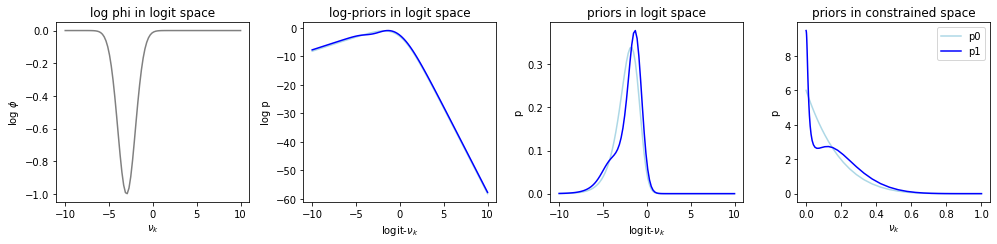

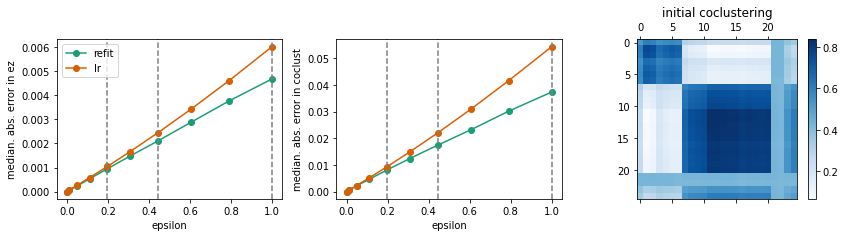

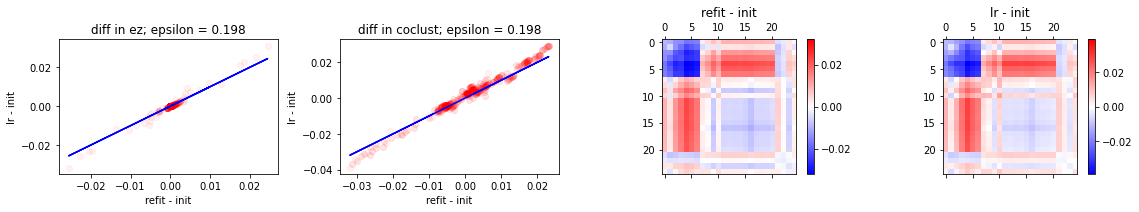

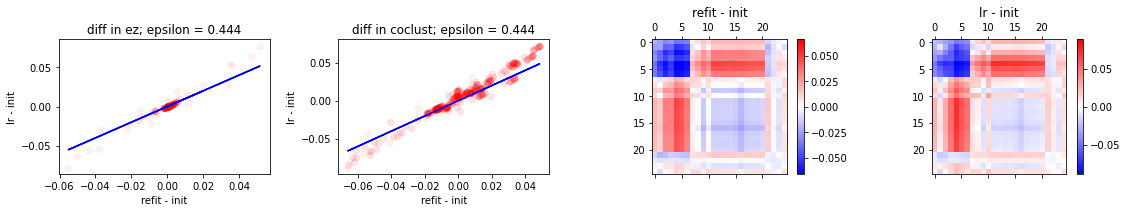

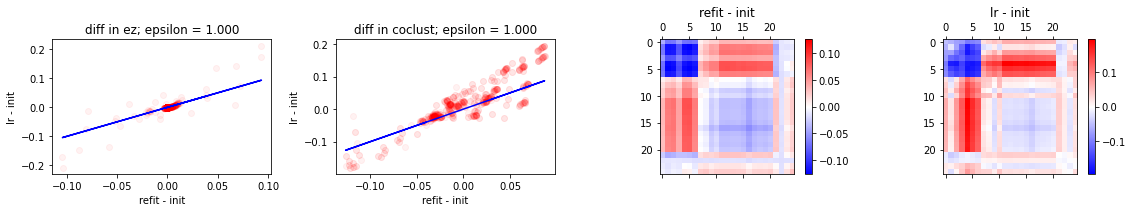

In [27]:
perturbation = 'gauss_pert2'
delta = -1
result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [4, 6, -1])